Lab 8, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import math

The objective of this laboratory work is to develop the estimation and tracking algorithm in
conditions of measurement gaps, that is of prime importance for many practical control and forecasting
problems. This will bring about a deeper understanding of main difficulties of practical Kalman filter
implementation and skills to overcome these difficulties to get optimal assimilation output. 

Let's generate a true trajectory $x_i$ of an object motion disturbed by normally distributed unbiased random acceleration $a_i$ with variance $\sigma_a^2 = 0.2^2$

$$
x_i = x_{i-1} + v_{i-1}T + \cfrac{a_{i-1}T^2}{2}
$$

$$
v_i = v_{i−1} + a_{i-1}T
$$

In [2]:
#noise of acceleration
sigmaacc = 0.2
acc = np.random.normal(loc=0.0, scale=sigmaacc, size=200)

#steps, speed and time interval
x = np.zeros(len(acc))
x[0] = 5

v = np.zeros(len(acc))
v[0] = 1

T = 1

#trajectory
for i in range(len(acc)):
    x[i] = x[i-1] + v[i-1]*T + acc[i-1]*(T**2)/2
    v[i] = v[i-1] + acc[i-1]*T

In general measurements of coordinate $x_i$ are performed every second with variance of measurement noise $\sigma_\eta^2 = 20^2$. Observation  interval is 200 seconds. However, there are measurement gaps. 

In [3]:
#noise of measurements
sigmaeta = 20
eta = np.random.normal(loc=0.0, scale=sigmaeta, size=200)

#measurements of the steps with gaps
P = 0.5
g = np.random.uniform(low=0.0, high=1.0, size=200)
z = np.zeros(len(acc))
for i in range(len(acc)):
    if g[i] > P:
        z[i] = x[i] + eta[i]
    else:
        z[i] = np.nan

Now we will develop Kalman filter to track moving object under these conditions

In [4]:
#making state vectors
X = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    X[i,0] = x[i]
    X[i,1] = v[i]
    X[i] = np.matrix([[x[i]], [v[i]]])
    
#making a transition matrix
PHI = np.matrix([[1, T], [0, 1]])

#making an input matrix
G = np.matrix([[T**2/2],[T]])

#making an observation matrix
H = np.matrix([1, 0])

#initial filtered estimate
X[0] = np.matrix([[2],[0]])

#initial filtration error covariance matrix P[i,i]
P = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    P[i] = np.matrix([[0, 0], [0, 0]])
P[0] = np.matrix([[10**2, 0], [0, 10**2]])

#prediction error covariance matrix P[i+1,i]
L = np.zeros((len(acc), 2, 2))
for i in range(len(acc)):
    L[i] = np.matrix([[0, 0], [0, 0]])

#covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
Q = (sigmaacc**2) * (G @ G.T)

#covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
R = np.matrix([sigmaeta**2])
e = np.zeros(len(acc))
K = np.zeros((len(acc), 2, 1))
for i in range(len(acc)):
    K[i] = np.matrix([[0], [0]])

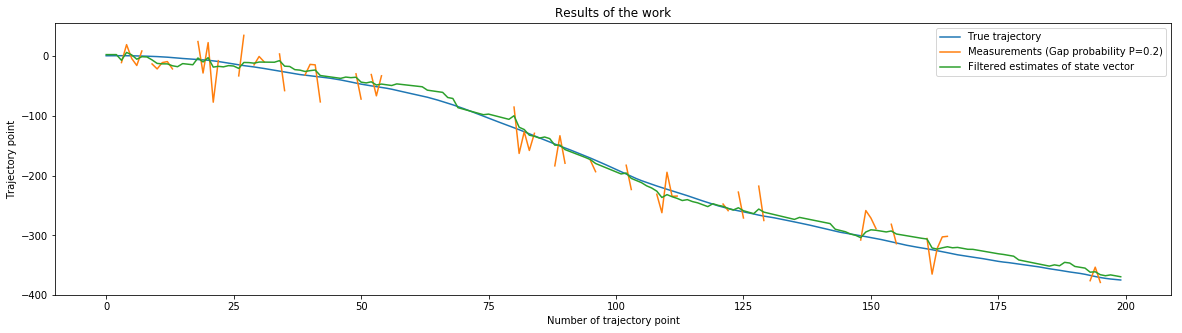

In [5]:
#Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction
    X[i] = PHI @ X[i-1]
    #Prediction error covariance matrix
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    L[i] = P[i]
    #Filtration is done only if measurements at step i are available
    if math.isnan(z[i]) == False:
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        #Filtration error covariance matrix
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    else: 
        X[i] = PHI @ X[i-1]
        P[i] = L[i]
    
plt.figure(figsize=(20,5))
plt.plot(x, '-')
plt.plot(z, '-')
plt.plot(X[:,0,0], '-')
plt.title('Results of the work')
plt.ylabel('Trajectory point')
plt.xlabel('Number of trajectory point')
plt.legend(['True trajectory', 'Measurements (Gap probability P=0.2)', 'Filtered estimates of state vector'], loc = 'best')
plt.show()

True_Error = P[:, 0, 0]

Let us determine filtered errors of estimation over 500 runs of filter.

In [6]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = v[i]
        X[i] = np.matrix([[x[i]], [v[i]]])

    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])

    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix R of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])
    e = np.zeros(len(acc))
    K = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        K[i] = np.matrix([[0], [0]])

    #Let's start Kalman filter algorithm
for i in range(1, len(acc)):
    #Prediction
    X[i] = PHI @ X[i-1]
    #Prediction error covariance matrix
    P[i] = (PHI @ P[i-1] @ PHI.T) + Q
    L[i] = P[i]
    #Filtration is done only if measurements at step i are available
    if math.isnan(z[i]) == False:
        #Filtration
        e[i] = (H @ P[i] @ H.T + R)**(-1)
        K[i] = e[i] * (P[i] @ H.T)
        X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
        #Filtration error covariance matrix
        P[i] = (np.identity(2) - K[i] @ H) @ P[i]
    else: 
        X[i] = PHI @ X[i]
        P[i] = L[i]
        
#Errors gathering
for i in range(3, len(acc)):
    Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared1 = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared1[i] += (1/(M-1))*Errors[j, i]

Let us also determine extrapolated errors of estimation (1 step ahead) over 500 runs of
filter.

In [7]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = v[i]
        X[i] = np.matrix([[x[i]], [v[i]]])

    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])

    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])
    e = np.zeros(len(acc))
    K = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        K[i] = np.matrix([[0], [0]])

   
    #Let's start 1-step extrapolation
    for i in range(len(acc) - 1):
        #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        if math.isnan(z[i]) == False:
            #Filtration
            e[i] = (H @ P[i] @ H.T + R)**(-1)
            K[i] = e[i] * (P[i] @ H.T)
            X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
            P[i] = (np.identity(2) - K[i] @ H) @ P[i]
        else:
            #Let's start 1-step extrapolation
            X[i] = PHI @ X[i]
        
#Errors gathering
for i in range(3, len(acc)):
    Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared2 = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared2[i] += (1/(M-1))*Errors[j, i]

Let us also determine extrapolated errors of estimation (7 steps ahead) over 500 runs of
filter.

In [8]:
M=500
Errors = np.zeros((M, len(acc)))

for j in range(M):
    #making state vectors
    X = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        X[i,0] = x[i]
        X[i,1] = v[i]
        X[i] = np.matrix([[x[i]], [v[i]]])

    #making a transition matrix
    PHI = np.matrix([[1, T], [0, 1]])

    #making an input matrix
    G = np.matrix([[T**2/2],[T]])

    #making an observation matrix
    H = np.matrix([1, 0])

    #initial filtered estimate
    X[0] = np.matrix([[2],[0]])

    #initial filtration error covariance matrix
    P = np.zeros((len(acc), 2, 2))
    for i in range(len(acc)):
        P[i] = np.matrix([[0, 0], [0, 0]])
    P[0] = np.matrix([[10**2, 0], [0, 10**2]])

    #covariance matrix Q of state noise \eta_i that is used in Kalman filter algorithm to determine prediction error covariance matrix
    Q = (sigmaacc**2) * (G @ G.T)

    #covariance matrix 𝑅 of measurements noise \eta_i that is used in Kalman filter algorithm to determine filter gain
    R = np.matrix([sigmaeta**2])
    e = np.zeros(len(acc))
    K = np.zeros((len(acc), 2, 1))
    for i in range(len(acc)):
        K[i] = np.matrix([[0], [0]])

   

    m=7
    #Let's start m-step extrapolation
    for i in range(len(acc) - m):
        #Prediction(extrapolation)
        X[i] = PHI @ X[i-1]
        P[i] = (PHI @ P[i-1] @ PHI.T) + Q
        if math.isnan(z[i]) == False:
            #Filtration
            e[i] = (H @ P[i] @ H.T + R)**(-1)
            K[i] = e[i] * (P[i] @ H.T)
            X[i] = X[i] + K[i]*np.array([z[i] - H @ X[i]])
            P[i] = (np.identity(2) - K[i] @ H) @ P[i]
        else:
            #Let's start m-step extrapolation
            X[i+m-1] = np.linalg.matrix_power(PHI, m-1) @ X[i]
        
#Errors gathering
for i in range(3, len(acc)):
    Errors[j, i] = (X[i,0,0] - x[i])**2
        

Fin_Err_squared3 = np.zeros(len(acc))
for i in range(len(acc)):
    for j in range(M):
        Fin_Err_squared3[i] += (1/(M-1))*Errors[j, i]

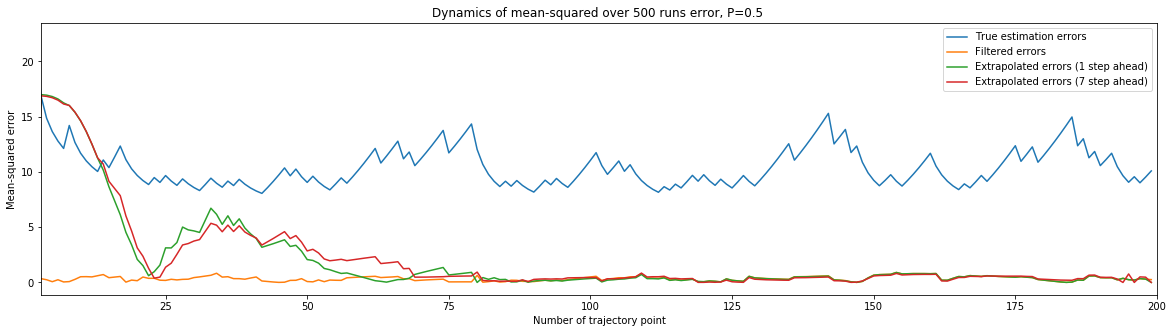

In [9]:
plt.figure(figsize=(20,5))
plt.plot(np.sqrt(True_Error), '-')
plt.plot(np.sqrt(Fin_Err_squared1), '-')
plt.plot(np.sqrt(Fin_Err_squared2), '-')
plt.plot(np.sqrt(Fin_Err_squared3), '-')
plt.title('Dynamics of mean-squared over 500 runs error, P=0.5 ')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.xlim((3,200))
plt.legend(['True estimation errors','Filtered errors', 'Extrapolated errors (1 step ahead)', 'Extrapolated errors (7 step ahead)'], loc = 'best')
plt.show()